In [1]:
# ============================================================
# CNN Advanced Practice Notebook 02
# Understanding Feature Maps in CNN
# ============================================================
# [KR]
# 목표:
# - CNN 각 합성곱 층(Conv layer)이 어떤 특징(feature)을 학습하는지 이해한다.
# - Conv1 / Conv2 feature map의 차이를 시각적으로 확인한다.
#
# [JP]
# 目的:
# - CNNにおける各畳み込み層がどのような特徴を学習するかを理解する。
# - Conv1 / Conv2 の特徴マップを可視化し、その違いを確認する。
#
# 핵심 개념:
# - Conv1 → 엣지, 색상 등 저수준 특징
# - Conv2 → 텍스처, 패턴 등 중간 수준 특징
# - Pooling → 해상도 감소 + 추상화
# - Filter → 학습된 특징 탐지기

In [2]:
# ------------------------------------------------------------
# 0) Library Import
# ------------------------------------------------------------
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input


C:\Users\JA60301\anaconda3\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [3]:
# ------------------------------------------------------------
# 1) Data Load & Preprocess (CIFAR-10)
# ------------------------------------------------------------
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# 픽셀값 정규화 (0~255 → 0~1)
x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0

In [4]:
# ------------------------------------------------------------
# 2) CNN Model Definition
# ------------------------------------------------------------
# 입력 이미지 크기: 32x32 RGB
inputs = Input(shape=(32, 32, 3))

# Conv Layer 1
# - 픽셀 밝기 변화, 색상 대비, 엣지 등 저수준 시각 특징 학습
x = Conv2D(16, (3, 3), activation="relu", name="conv1")(inputs)
x = MaxPooling2D()(x)

# Conv Layer 2
# - conv1에서 추출된 특징을 조합
# - 텍스처, 반복 패턴, 부분 형태 등 중간 수준 특징 학습
x = Conv2D(32, (3, 3), activation="relu", name="conv2")(x)
x = MaxPooling2D()(x)

# Feature map을 1차원 벡터로 변환
x = Flatten()(x)

# Output Layer
# - CIFAR-10: 10개 클래스 분류
outputs = Dense(10, activation="softmax")(x)

# Model 정의
model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 30, 30, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 15, 15, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2 (Conv2D)                       │ (None, 13, 13, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10)                  │          11,530 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,618 (64.91 KB)

 Trainable params: 16,618 (64.91 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# ------------------------------------------------------------
# 3) Model Training (간단한 학습)
# ------------------------------------------------------------
# 목적:
# - feature map 시각화를 위한 최소한의 학습
# - 성능 자체가 목적은 아님
model.fit(
    x_train, y_train,
    epochs=3,
    validation_split=0.2,
    verbose=1
)

Epoch 1/3
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.4363 - loss: 1.5750 - val_accuracy: 0.5219 - val_loss: 1.3573
Epoch 2/3
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.5472 - loss: 1.2868 - val_accuracy: 0.5637 - val_loss: 1.2474
Epoch 3/3
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.5978 - loss: 1.1571 - val_accuracy: 0.6028 - val_loss: 1.1447


In [6]:
# ------------------------------------------------------------
# 4) Dummy Input 생성 (Forward Pass 트리거)
# ------------------------------------------------------------
# 실제 데이터와 동일한 shape의 임의 입력
# - 학습 목적아 아님
# - 모델 내부 텐서 그래프를 확정하기 위한 관례적인 단계
dummy_image = tf.random.normal((1, 32, 32, 3))

# forward pass 실행
_ = model(dummy_image)

In [7]:
# ------------------------------------------------------------
# 5) Feature Map 추출 모델 생성
# ------------------------------------------------------------
# Conv layer들의 출력을 모아 새로운 모델 정의
layer_outputs = [
    layer.output for layer in model.layers
    if isinstance(layer, Conv2D)
]

activation_model = Model(
    inputs=model.input,
    outputs=layer_outputs
)

# dummy image를 통과시켜 feature map 추출
activations = activation_model.predict(dummy_image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


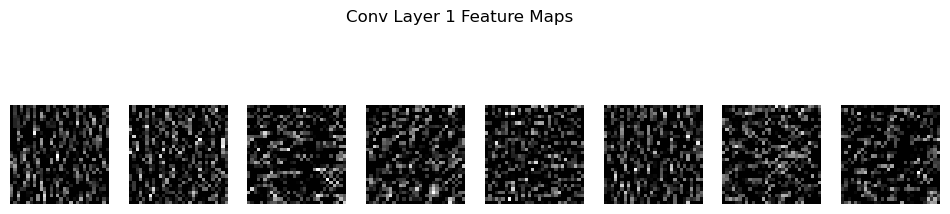

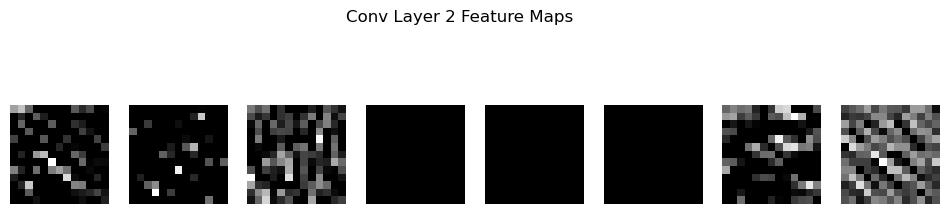

In [8]:
# ------------------------------------------------------------
# 6) Feature Map 시각화
# ------------------------------------------------------------
for idx, activation in enumerate(activations):

    plt.figure(figsize=(12, 3))

    # 각 Conv layer에서 최대 8개의 feature map 시각화
    for i in range(min(8, activation.shape[-1])):
        plt.subplot(1, 8, i + 1)
        plt.imshow(activation[0, :, :, i], cmap="gray")
        plt.axis("off")

    

    plt.suptitle(f"Conv Layer {idx + 1} Feature Maps")
    plt.show()

In [9]:
# ------------------------------------------------------------
# 7) Analysis Questions
# ------------------------------------------------------------

# 1) Conv1과 Conv2 feature map의 시각적 차이
# ------------------------------------------------
# - Dummy image는 의미 있는 구조가 아닌 노이즈 입력
# - Conv1:
#   * 작은 3x3 필터로 픽셀 단위 밝기/색상 변화에 즉각 반응
#   * 미세하고 로컬한 패턴 위주
# - Conv2:
#   * Conv1의 feature map을 입력으로 사용
#   * Pooling으로 해상도가 감소
#   * 더 큰 영역의 조합된 패턴에 반응

# 2) Pooling 전/후 feature map 크기 변화
# ------------------------------------------------
# 예시:
# 입력 이미지        : 32 x 32 x 3
# Conv1 출력         : 30 x 30 x 16
# MaxPooling1 출력   : 15 x 15 x 16
# Conv2 출력         : 13 x 13 x 32
# MaxPooling2 출력   : 6  x 6  x 32

# 3) 필터 수를 늘리면 발생하는 변화
# ------------------------------------------------
# - 학습 가능한 특징(feature)의 종류 증가
# - 모델의 표현력(representation power) 향상
# - 파라미터 수 및 연산량 증가
# - 과적합(overfitting) 위험 증가